In [1]:
# Importing essential libraries for image image_image_data preprocessing, visualization, machine learning, and TensorFlow model development.

import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.preprocessing.image import Imageimage_image_dataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import zipfile
import sklearn.preprocessing as preprocessing

In [2]:
train_dir ="E:/new project/assignment/dogs-vs-cats-redux-kernels-edition/test"
test_dir="E:/new project/assignment/dogs-vs-cats-redux-kernels-edition/train"

In [3]:
# Define the directory containing image data
image_directory = "dogs-vs-cats-redux-kernels-edition/train/train/"

# List all filenames in the image directory
file_names = os.listdir(image_directory)

# Extract labels from filenames (assuming filenames are in the format "label.xxx.jpg")
labels = [file.split(".")[0] for file in file_names]

# Create a DataFrame to organize image filenames and their corresponding labels
data = pd.DataFrame({"Filename": file_names, "Label": labels})

# Display the first few rows of the DataFrame
data.head()


,Filename,Label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [4]:
image_width = 64
image_height = 64
batch_size = 512

In [5]:
# Splitting the data into training, testing, and validation sets

# Extract labels for splitting
labels = data['Label']

# Split the data into training (80%) and temporary (20%) sets while ensuring label stratification
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state=42)

# Extract labels for further splitting
label_test_val = X_temp['Label']

# Split the temporary set into testing (50%) and validation (50%) sets while ensuring label stratification
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state=42)

# Print the shapes of the resulting datasets
print('The shape of the training data:', X_train.shape)
print('The shape of the testing data:', X_test.shape)
print('The shape of the validation data:', X_val.shape)


The shape of the training data: (20000, 2)
The shape of the testing data: (2500, 2)
The shape of the validation data: (2500, 2)


In [6]:
# Importing necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Data augmentation for validation and test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255)



In [7]:

# Define the image size
image_size = 64

# Creating data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory='dogs-vs-cats-redux-kernels-edition/train/train/',
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    target_size=(image_size, image_size)
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory='dogs-vs-cats-redux-kernels-edition/train/train/',
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory='dogs-vs-cats-redux-kernels-edition/train/train/',
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)


Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [8]:
# Creating a convolutional neural network (CNN) model

image_channel = 3

model = Sequential()

# Input Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax'))

# Display model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       2

In [9]:
# Define early stopping callback to monitor validation loss and restore best weights
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights to the best observed during training
    verbose=0  # Set verbosity to control the amount of output during training (0: silent)
)


In [10]:
# Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy metric
model.compile(
    optimizer='adam',  # Optimizer for training
    loss='binary_crossentropy',  # Loss function for binary classification
    metrics=['accuracy']  # Evaluation metric to monitor during training
)


In [11]:
# Train the model using the provided data generators and callbacks

cat_dog_history = model.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    callbacks=[early_stopping],  # Early stopping callback
    epochs=10,  # Number of training epochs
    batch_size=32  # Batch size for training
    # steps_per_epoch=len(train_generator),  # Optionally specify steps per epoch
    # validation_steps=len(val_generator),  # Optionally specify validation steps
)

Epoch 1/10
40/40 [==============================] - 360s 9s/step - loss: 0.7441 - accuracy: 0.6269 - val_loss: 0.7482 - val_accuracy: 0.5000
Epoch 2/10
40/40 [==============================] - 121s 3s/step - loss: 0.6192 - accuracy: 0.6920 - val_loss: 0.8649 - val_accuracy: 0.5000
Epoch 3/10
40/40 [==============================] - 124s 3s/step - loss: 0.5635 - accuracy: 0.7215 - val_loss: 0.9653 - val_accuracy: 0.5000
Epoch 4/10
40/40 [==============================] - 125s 3s/step - loss: 0.5203 - accuracy: 0.7508 - val_loss: 0.9101 - val_accuracy: 0.5000


In [12]:
# Save the trained model to a file

model.save("model1.h5")  # Save the model to a file named "model1.h5"


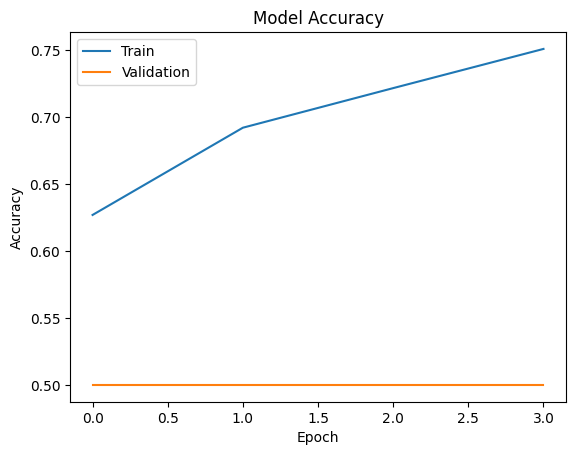

In [13]:
# Visualize model accuracy history

history = cat_dog_history  # Assign the training history to the 'history' variable

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


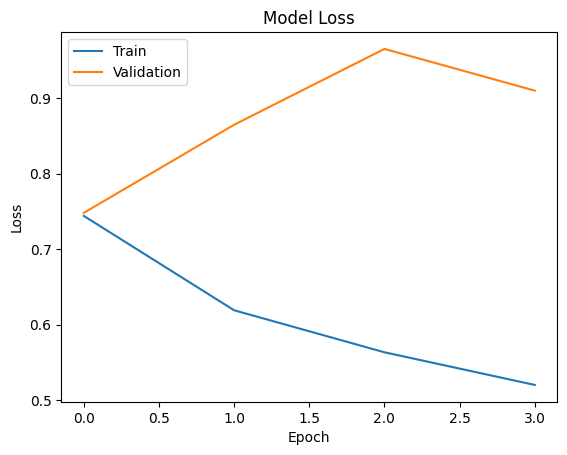

In [14]:
# Visualize model loss history

history = cat_dog_history  # Assign the training history to the 'history' variable

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [15]:
# Create a Sequential model for a convolutional neural network (CNN)

model = Sequential()

# Input Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, image_channel)))
# No BatchNormalization in this version
model.add(MaxPooling2D(pool_size=(2, 2)))
# No Dropout in this version

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu'))
# No BatchNormalization in this version
model.add(MaxPooling2D(pool_size=(2, 2)))
# No Dropout in this version

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu'))
# No BatchNormalization in this version
model.add(MaxPooling2D(pool_size=(2, 2)))
# No Dropout in this version

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu'))
# No BatchNormalization in this version
model.add(MaxPooling2D(pool_size=(2, 2)))
# No Dropout in this version

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# No BatchNormalization in this version
# No Dropout in this version

# Output layer
model.add(Dense(2, activation='sigmoid'))

# Display model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 128)       

In [16]:
# Define early stopping callback to monitor validation loss and restore best weights

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights to the best observed during training
    verbose=0  # Set verbosity to control the amount of output during training (0: silent)
)


In [17]:
# Compile the model with the Adam optimizer, categorical cross-entropy loss, and accuracy metric

model.compile(
    optimizer='adam',  # Optimizer for training
    loss='categorical_crossentropy',  # Loss function for categorical classification
    metrics=['accuracy']  # Evaluation metric to monitor during training
)


In [18]:
# Train the model using the provided data generators and callbacks

training_history = model.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    callbacks=[early_stopping],  # Early stopping callback
    epochs=10,  # Number of training epochs
    batch_size=32  # Batch size for training
)


Epoch 1/10
40/40 [==============================] - 105s 3s/step - loss: 0.6784 - accuracy: 0.5684 - val_loss: 0.6545 - val_accuracy: 0.6172
Epoch 2/10
40/40 [==============================] - 104s 3s/step - loss: 0.6293 - accuracy: 0.6482 - val_loss: 0.6124 - val_accuracy: 0.6580
Epoch 3/10
40/40 [==============================] - 103s 3s/step - loss: 0.5932 - accuracy: 0.6813 - val_loss: 0.5437 - val_accuracy: 0.7264
Epoch 4/10
40/40 [==============================] - 99s 2s/step - loss: 0.5561 - accuracy: 0.7175 - val_loss: 0.5002 - val_accuracy: 0.7532
Epoch 5/10
40/40 [==============================] - 94s 2s/step - loss: 0.5261 - accuracy: 0.7401 - val_loss: 0.4651 - val_accuracy: 0.7868
Epoch 6/10
40/40 [==============================] - 94s 2s/step - loss: 0.4905 - accuracy: 0.7601 - val_loss: 0.4460 - val_accuracy: 0.7968
Epoch 7/10
40/40 [==============================] - 82s 2s/step - loss: 0.4719 - accuracy: 0.7750 - val_loss: 0.4134 - val_accuracy: 0.8164
Epoch 8/10
40/40 

In [19]:
# Save the trained model to a file

model.save("model2.h5")  # Save the model to a file named "model2.h5"


In [20]:
from keras.models import load_model

# Load a pre-trained model from a file
loaded_model = load_model("model1.h5")  # Load the model from the file "model1.h5"


In [21]:
# Use the trained model to make predictions on the test data

predicted_labels = model.predict(test_generator)  # Predict labels for the test data


5/5 [==============================] - 26s 6s/step


In [22]:
# Create a label encoder
label_encoder = preprocessing.LabelEncoder()  # Create a label encoder object

# Fit the encoder to the data and transform the data
# Replace 'label' with the correct column name if it's different
encoded_labels = label_encoder.fit_transform(X_test['Label'])  # Fit and transform labels

print(encoded_labels)  # Print the encoded labels


[1 1 1 ... 1 1 1]


In [23]:
# Convert predicted probabilities to class labels

predicted_classes = np.argmax(predicted_labels, axis=1)


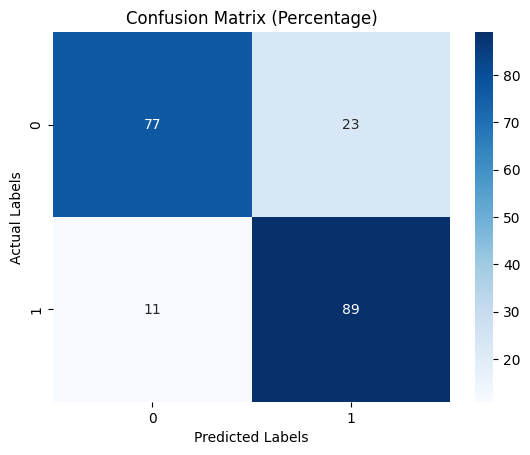

Sensitivity: 0.79


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define a function to visualize the confusion matrix and calculate sensitivity

def plot_confusion_matrix(Y_pred_reverse, Y_test_reverse):
    # Compute the confusion matrix
    cm = confusion_matrix(Y_test_reverse, Y_pred_reverse)
    
    # Compute percentages
    cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) * 100
    
    # Plot the confusion matrix
    sns.heatmap(cm_percent, annot=True, cmap="Blues")
    plt.title("Confusion Matrix (Percentage)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.show()
    
    # Calculate sensitivity
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    print("Sensitivity: {0:.2f}".format(sensitivity))

# Call the function with predicted and true labels
plot_confusion_matrix(predicted_classes, encoded_labels)


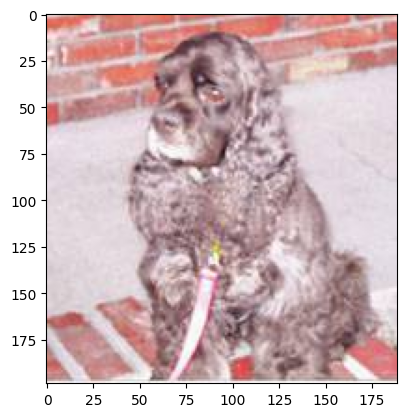

In [37]:
# Import necessary libraries for image display

import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import matplotlib.image as mpimg  # Import Matplotlib for working with images

# Load and display an image

image_dir = "dogs-vs-cats-redux-kernels-edition/train/train/"  # Modify this to the correct path to the image directory
image_path = image_dir + "dog.8022.jpg"  # Define the path to the image file
image = mpimg.imread(image_path)  # Load the image using Matplotlib's imread
fig, ax = plt.subplots()  # Create a figure and axes for displaying the image
ax.imshow(image)  # Display the loaded image using Matplotlib


In [38]:
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator class
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=image_dir,
    x_col="Filename",
    y_col="Label",
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# Use the trained model to make predictions on the test data
Y_pred = model.predict(test_generator)  # Predict labels for the test data

# Create a label encoder
label_encoder = preprocessing.LabelEncoder()  # Create a label encoder object

# Fit the encoder to the data and transform the data
# Replace 'label' with the correct column name if it's different
encoded = label_encoder.fit_transform(X_test['Label'])  # Fit and transform labels

# Iterate through the predicted and encoded labels to check for mismatches
for i in range(len(Y_pred)):
    if not np.array_equal(Y_pred[i], encoded[i]):  # Check if the predicted label does not match the encoded label
        print("Mismatch at index", i)  # Print the index of the mismatch


Found 2500 validated image filenames belonging to 2 classes.
79/79 [==============================] - 3s 43ms/step
Mismatch at index 0
Mismatch at index 1
Mismatch at index 2
Mismatch at index 3
Mismatch at index 4
Mismatch at index 5
Mismatch at index 6
Mismatch at index 7
Mismatch at index 8
Mismatch at index 9
Mismatch at index 10
Mismatch at index 11
Mismatch at index 12
Mismatch at index 13
Mismatch at index 14
Mismatch at index 15
Mismatch at index 16
Mismatch at index 17
Mismatch at index 18
Mismatch at index 19
Mismatch at index 20
Mismatch at index 21
Mismatch at index 22
Mismatch at index 23
Mismatch at index 24
Mismatch at index 25
Mismatch at index 26
Mismatch at index 27
Mismatch at index 28
Mismatch at index 29
Mismatch at index 30
Mismatch at index 31
Mismatch at index 32
Mismatch at index 33
Mismatch at index 34
Mismatch at index 35
Mismatch at index 36
Mismatch at index 37
Mismatch at index 38
Mismatch at index 39
Mismatch at index 40
Mismatch at index 41
Mismatch at i

In [39]:
X_test.iloc[217]

Filename    dog.8642.jpg
Label                dog
Name: 23493, dtype: object

In [40]:
# Import the necessary library for F1 score calculation

from sklearn.metrics import f1_score  # Import the f1_score function
from sklearn.preprocessing import LabelBinarizer  # Import the LabelBinarizer class

# Create a label binarizer object
lb = LabelBinarizer()

# Binarize the encoded labels
y_true = lb.fit_transform(encoded)

# Convert predicted probabilities to binary values
y_pred = np.argmax(Y_pred, axis=1)

# Calculate the macro F1 score
f1 = f1_score(y_true=y_true, y_pred=y_pred, average='macro')  # Compute macro F1 score
print("F1 SCORE:", f1)  # Print the computed macro F1 score


F1 SCORE: 0.5021107292889306


In [41]:
# Import the necessary library for ROC AUC score calculation
from sklearn.metrics import roc_auc_score

# Calculate the ROC AUC score for a binary classification task
roc_auc = roc_auc_score(encoded[:2500], Y_pred[:2500, 1])  # Compute ROC AUC score

# Print the calculated ROC AUC score
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.5035872


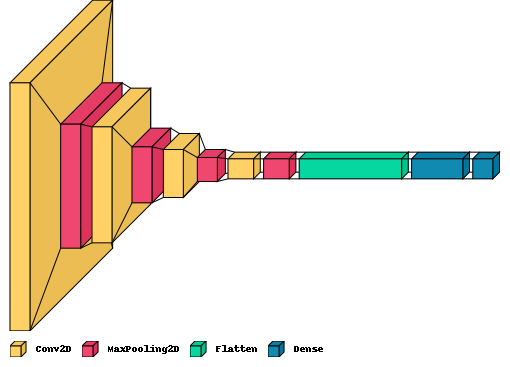

In [42]:
# Import the necessary library for visualizing the Keras model
import visualkeras

# Visualize the Keras model with a layered view
visualkeras.layered_view(model=model, legend=True)
